## Implementing a GPT model from Scratch To Generate Text

In this notebook, we implement a GPT-like LLM model from scratch to generate Text. let's Go

In [11]:
#configuration for GPT2 we will be using

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12, # numbers of head in multiattention head
    "n_layers":12, #number of transformer bloclks
    "drop_rate": 0.1,
    "qkv_bias": False, #"first we don't add bias to linear layers for keys, value and queries parameters"
}


In [19]:
#let's create a GBT backbone call DummyGPTModel first before adding more sophistocation

import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"]) #token emmbedding layer
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"]) #position embedding layer
        self.drop_emb = nn.Dropout(cfg["drop_rate"]) #dropout layer
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range (cfg["n_layers"])])   #A
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])                      #B
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx) #token embeddings
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        x = tok_embeds + pos_embeds #add token and position embeddings
        x = self.drop_emb(x) #apply dropout
        x = self.trf_blocks(x) #pass through transformer blocks
        x = self.final_norm(x) #apply final layer normalization
        logits = self.out_head(x) #output layer to get logits for each token in vocabulary
        return logits
    

class DummyTransformerBlock(nn.Module):                                             #C
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):                                                              #D
        return x
    
class DummyLayerNorm(nn.Module):                                              #E                        
    def __init__(self, normalized_shape, eps=1e-5):                          #F                     
        super().__init__()

    def forward (self, x):
        return x



In [20]:
#A Use a placeholder for TransformerBlock
#B Use a placeholder for LayerNorm
#C A simple placeholder class that will be replaced by a real TransformerBlock later
#D This block does nothing and just returns its input.
#E A simple placeholder class that will be replaced by a real NormBlock later
#F The parameters here are just to mimic the LayerNorm interface.

In [21]:
#we will use a batch of two input to try our DummyGPTModel
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)


tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [22]:
#"using it with our DummyGPTModel"
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output logits shape:", logits.shape) #should be (2, seq_len, vocab_size)
print(logits)

Output logits shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


In [ ]:
#let's implement layer normalisation to improve stability and efficiency of neural networks (avoid vanishing/exploding gradients)   
# the goal is to adjust an NN output so that it has a mean of 0 and a standard deviation of 1

In [ ]:
#exemple
torch.manual_seed(123)
batch_example = torch.randn(2,5)
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU()) # relut thresholds negative values to zero (it's a activation function)
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [25]:
#let's examine the mean and standard deviation of the output
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("Mean:", mean)
print("variance:", var)

Mean: tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
variance: tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [26]:
#let's apply layer normalization
# it consist of subtracting the mean and dividing by the standard deviation

out_norm = (out-mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized Output:", out_norm)
print("After LayerNorm - Mean:", mean)
print("After LayerNorm - Variance:", var)

Normalized Output: tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
After LayerNorm - Mean: tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
After LayerNorm - Variance: tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [27]:
# we can turn off scientific notation for clarity
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [28]:
#let's create the class

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim)) #trainable parameter to learn correctly scaling
        self.shift = nn.Parameter(torch.zeros(emb_dim)) #trainable parameter to learn correctly scaling

    def forward(self,x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True)
        x_norm = (x-mean) / torch.sqrt(var + self.eps) #to prevent division by 0
        return self.scale * x_norm + self.shift

NB: We use biased variance (dividing by n ,number of input in the variance formula, instead of n-1)
but this is not important here because as in our case, n is large n~n-1

In [29]:
#trying the layerNorm Module
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, keepdim=True, unbiased=False) #unbiased=False to get the exact variance (divided by n)
print("Mean: \n", mean)
print("Variance: \n", var)

Mean: 
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance: 
 tensor([[0.8000],
        [0.8000]], grad_fn=<VarBackward0>)


In [ ]:
#now we implement GELU (Gaussian Error Linear Unit) activation fonction very popular in transformer models
#GELU(x) = x * P(X <= x) where X ~ N(0,1) GELU(x) ~ x * 0.5 * (1 + tanh(sqrt(2/pi) * (x + 0.044715 * x^3)))

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5*x*(1+torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi))* (x+0.044715* torch.pow(x,3))))

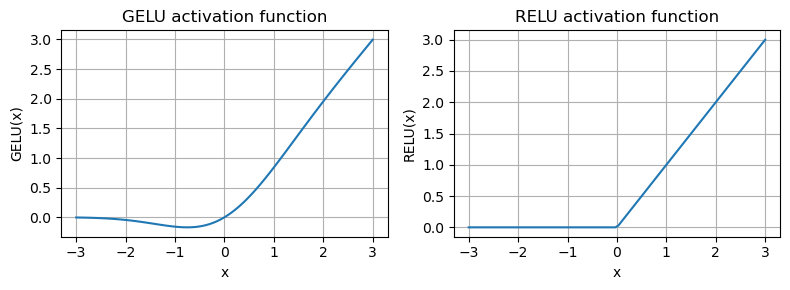

In [32]:
#"lts's plot the functions side by side to compare them"

import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3,3,100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8,3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "RELU"])):
    plt.subplot(1,2,i+1)
    plt.plot(x,y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid()
plt.tight_layout()
plt.show()

In [34]:
#let's use the GELU Module to implement the FeedForward module we will use later for transformer block
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]), #increase dimension by 4 times
            GELU(),
            nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"]) #project back to original dimension
        )

    def forward(self, x):
        return self.layers(x)

In [35]:
#test with a token embedding size of 768 and feed it a batch input with 2 samples and 3 tokens each
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2,3,768)
out = ffn(x)
print(out.shape) #should be (2,3,768)

torch.Size([2, 3, 768])


In [37]:
# now let's discuss the concep of shurcut connections also called residual connections or skip connections (it helps avoid vanishing gradients)
#it consist of adding the input of a layer to its output before passing it to the next layer" (so gradient i slarger and allow more learning)

# a neural network to illustrate shortcut connections
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shorcut):
        super().__init__()
        self.use_shortcut = use_shorcut
        self.layers = nn.ModuleList([
            #implement5 layers
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()), #layer 1
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()), #layer 2
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()), #layer 3
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()), #layer 4
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5])) #layer 5 (no activation function here)
        ])

    def forward(self, x):
        for layer in self.layers:
            #compute the layer output
            layer_output = layer(x)
            #check if shorcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else: x = layer_output
        return x

In [ ]:
#testing first without shortcut connections
layer_sizes = [3,3,3,3,3,1]
sample_input = torch.tensor([[1.,0.,-1.]])
torch.manual_seed(123)
model_without_shorcut = ExampleDeepNeuralNetwork(layer_sizes, use_shorcut=False)




In [39]:
# a function to computes gradient
def print_gradients(model, x):
    #forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    #calculate loss based on how close the target and the output are
    loss = nn.MSELoss()
    loss = loss(output, target)

    #backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weigths
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [40]:
#let's apply the function to our model without shortcut connections
print_gradients(model_without_shorcut, sample_input)

layers.0.0.weight has gradient mean of 0.0006289089797064662
layers.1.0.weight has gradient mean of 0.00037444636109285057
layers.2.0.weight has gradient mean of 0.0022296393290162086
layers.3.0.weight has gradient mean of 0.004360969644039869
layers.4.0.weight has gradient mean of 0.01574220508337021


As we can see based on the output of the print_gradients function, the gradients become
smaller as we progress from the last layer (layers.4) to the first layer (layers.0), which
is a phenomenon called the vanishing gradient problem.

In [ ]:
# a model with shortcut connections
torch.manual_seed(123)
model_without_shorcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shorcut=True
)
print_gradients(model_without_shorcut, sample_input)
#we can see that the gradients are larger and stabilise when using shortcut connections, which can help with learning in deep networks

layers.0.0.weight has gradient mean of 0.25278669595718384
layers.1.0.weight has gradient mean of 0.2359604835510254
layers.2.0.weight has gradient mean of 0.3751014769077301
layers.3.0.weight has gradient mean of 0.3039548695087433
layers.4.0.weight has gradient mean of 1.5117788314819336


#### Connecting attention and linear layers in a transformer block

In [45]:
# the transformer block
import sys
sys.path.append("..") #to import from the parent directory
from utils import MultiHeadAttention

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads = cfg["n_heads"],
            dropout = cfg["drop_rate"],
            qkv_bias = cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])


    def forward(self,x):
                                                                                #A
        shortcut =x
        x = self.norm1(x)
        x= self.att(x)
        x= self.drop_shortcut(x)
        x = x + shortcut #add the original input (shortcut connection)

        shortcut = x
        x  = self.norm2(x)                                                      #B
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut                                                         #C                                             
        return x

#A Shortcut connection for attention block
#B Shortcut connection for feed forward block
#C Add the original input back

In [46]:
#testing
torch.manual_seed(123)
x = torch.rand(2,4,768)                                     #A
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape) #should be (2,4,768)

#A Create sample input of shape [batch_size, num_tokens, emb_dim]

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


#### Coding the GPT model

In [48]:
#The GPT Model architecture implementation
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device)) #A

        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)

        return logits
    
#A The device setting will allow us to train the model on a CPU or GPU, depending on which device the input data sits

In [49]:
#testing
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch", batch)
print("Output logits shape:", out.shape) #should be (2, seq_len, vocab_size)
print(out)

Input batch tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Output logits shape: torch.Size([2, 4, 50257])
tensor([[[-0.6553,  0.4158,  0.3105,  ..., -0.3362, -0.7134, -0.4805],
         [ 0.8252, -0.8948, -0.6052,  ..., -0.6546, -0.7374, -0.3287],
         [ 0.2420,  0.0976, -0.6097,  ..., -0.1342, -0.9561, -0.6095],
         [-0.9763,  0.5278, -0.4405,  ...,  0.8214,  0.0259, -0.5252]],

        [[-0.5229,  0.5286, -0.0876,  ..., -0.7068, -0.6913, -0.0683],
         [ 0.1366, -0.0485,  0.2685,  ...,  0.2380, -0.6056,  0.4005],
         [ 0.6425,  0.7836, -0.2196,  ..., -0.0201,  0.0758, -0.1705],
         [-0.4148, -0.0514,  0.2661,  ...,  0.8324, -0.6698,  0.1016]]],
       grad_fn=<UnsafeViewBackward0>)


Computing the size of the model

In [50]:
total_params = sum(p.numel() for p in model.parameters())
print(f"total number of parameters: {total_params:,}")

total number of parameters: 163,009,536


this 163M is different from 124M we are speaking about till reading the course book
It's due to a concept called weight tying. the original GPT-2 architechture is reusing the weights from the token embedding layer in its output layer.

to undersand let's go throught some exmaple

In [51]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
output layer shape: torch.Size([50257, 768])


In [52]:
#let's remove the count of output layer parameters
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weigth tying: {total_params_gpt2:,}")

Number of trainable parameters considering weigth tying: 124,412,160


NB: Weight tying is a technique where the weights of the input embedding layer and the output layer are shared to reduce the number of parameters in the model.
in GPT2 the token embedding layer and the output layer share the same weights
but in modern  implementation of LLMs weight tying is not always used

In [55]:
#EXERCISE 4.1 NUMBER OF PARAMETERS IN FEED FORWARD AND ATTENTION MODULES

ff_num_params = sum(p.numel() for p in FeedForward(GPT_CONFIG_124M).parameters())
print(f"Number of parameters in FeedForward module: {ff_num_params:,}")
attention_num_params = sum(p.numel() for p in model.trf_blocks[0].att.parameters())
print(f"Number of parameters in Attention module: {attention_num_params:,}")

Number of parameters in FeedForward module: 4,722,432
Number of parameters in Attention module: 2,360,064


Computing the memory requirements of our 163M parameters GPT


In [56]:
total_size_bytes = total_params * 4   #A
total_size_mb = total_size_bytes / (1024**2)    #B
print(f"Total size of the model : {total_size_mb:.2f} MB")
#A Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
#B Convert to megabytes

Total size of the model : 621.83 MB


In [61]:
#transform the output fom GPT in text
#A function for the GPT model to generate text

def generate_text_simple(model, idx, max_new_tokens, context_size): #A
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]                           #B
        with torch.no_grad():
            logits = model(idx_cond)
        
        logits = logits[:, -1, :]                                  #C
        probas = torch.softmax(logits, dim=-1)                       #D
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  #E
        idx = torch.cat((idx, idx_next), dim=1)                   #F

    return idx

#A idx is a (batch, n_tokens) array of indices in the current context
#B Crop current context if it exceeds the supported context size E.g., if LLM supports only 5 tokens, and the
#context size is 10 then only the last 5 tokens are used as context
#C Focus only on the last time step, so that (batch, n_token, vocab_size) becomes (batch, vocab_size)
#D probas has shape (batch, vocab_size)
#E idx_next has shape (batch, 1)
#F Append sampled index to the running sequence, where idx has shape (batch, n_tokens+1)

In [62]:
#test
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0) #add batch dimension
print("encoded_tensor shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor shape: torch.Size([1, 4])


Next, we put the model into .eval() mode, which disables random components like
dropout, which are only used during training, and use the generate_text_simple function
on the encoded input tensor

In [63]:
model.eval() #set model to evaluation mode (disable dropout)
out = generate_text_simple(
    model=model,
    idx = encoded_tensor,
    max_new_tokens=6,
    context_size = GPT_CONFIG_124M["context_length"]
)
print("Output indices:", out)
print("output length:", len(out[0]))


Output indices: tensor([[15496,    11,   314,   716, 37532, 49980,  1114, 46546, 23696, 49073]])
output length: 10


In [64]:
#convert output indices to text
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Ae thefts For Droid analyticsAbyss
